In this notebook, we demonstrate how to train inverse models using the `ncpi` package. We use a simple linear Gaussian simulator that takes a parameter vector `theta` and returns a noisy observation. Specifically, the simulator adds a constant offset of 1.0 to `theta` and then adds Gaussian noise with a standard deviation of 0.1, so the output is `theta + 1.0 + noise`.

We will train two types of inverse models: a Multi-Layer Perceptron (MLP), which learns to predict the parameters directly from the observations, and a Neural Posterior Estimator (NPE), which learns to approximate the posterior distribution of the parameters given the observations. While the MLP provides point estimates of `theta`, the NPE captures uncertainty by modeling the full posterior distribution.

**Note**: For comprehensive guidance on how to use **`repeated K-Fold cross-validation`**, including examples across **`different learning models`**, refer to the tutorial for <a href="../tutorials/researchers_ML_SBI.html" target="_blank" rel="noopener">*Researchers in machine learning and SBI*</a>.

In [1]:
import numpy as np

# Parameters for the simulation
n_samples = 1000
num_dim = 3

def simulator(theta):
    # linear Gaussian
    return theta + 1.0 + np.random.randn(*theta.shape) * 0.1

# Generate simulation data
theta = np.random.randn(n_samples, num_dim)
X = simulator(theta)

Now, we split the data into 90% for training and 10% for testing.

In [2]:
# Split simulation data into 90% training and 10% test data
indices = np.arange(n_samples)
np.random.shuffle(indices)
split = int(0.9 * len(indices))
train_indices = indices[:split]
test_indices = indices[split:]

X_train = X[train_indices]
theta_train = theta[train_indices]
X_test = X[test_indices]
theta_test = theta[test_indices]

We will first train a MLP model to learn the mapping from observations `X` to parameters `theta`.

In [3]:
import ncpi

# Create the inference object and add simulation data
inference = ncpi.Inference(model='MLPRegressor',
                           hyperparams={'hidden_layer_sizes': (200,200,200),
                                        'max_iter': 200,
                                        'tol': 0.0001,
                                        'n_iter_no_change': 10})
inference.add_simulation_data(X_train, theta_train)

# Create a scaler for the features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

# Train the model
inference.train(param_grid=None, scaler=scaler)


Model saved at 'data/model.pkl'
Scaler saved at 'data/scaler.pkl'


We can now evaluate the MLP model on the test data to see how well it predicts the parameters.

Computing predictions: 100%|██████████| 34/34 [00:01<00:00, 22.84it/s]


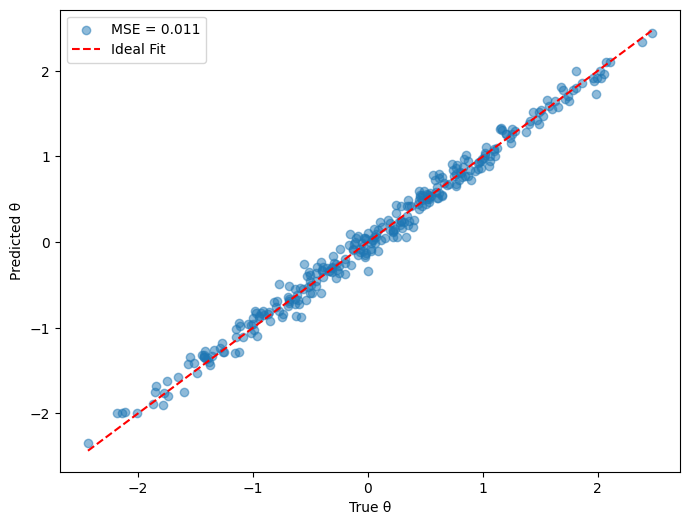

In [4]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

# Evaluate the model using the test data
predictions = inference.predict(X_test, scaler=scaler)

# Calculate MSE
mse = mean_squared_error(theta_test, predictions)

# Plot real vs predicted values
plt.figure(figsize=(8, 6))
plt.scatter(theta_test, predictions, alpha=0.5, label=f'MSE = {mse:.3f}')
plt.plot([theta_test.min(), theta_test.max()], [theta_test.min(), theta_test.max()], 'r--', label='Ideal Fit')
plt.xlabel('True θ')
plt.ylabel('Predicted θ')
plt.legend()
plt.show()

Next we will train a NPE model from sbi package.

In [5]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) # Suppress TqdmWarnings
warnings.filterwarnings("ignore", category=UserWarning) # Suppress sbi UserWarnings

inference = ncpi.Inference(model='NPE',
                           hyperparams={'prior': None,
                                        'density_estimator': {'model':"nsf",
                                                              'hidden_features':50,
                                                              'num_transforms':3}})
inference.add_simulation_data(X_train, theta_train)

# Create a scaler for the features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

inference.train(param_grid=None, scaler=scaler)

 Neural network successfully converged after 128 epochs.
Model saved at 'data/model.pkl'
Scaler saved at 'data/scaler.pkl'
Density estimator saved at 'data/density_estimator.pkl'


We can use the predict method to get mean predictions from the posterior distribution learned by the NPE model. In this way, we can obtain point estimates of the parameters similar to the MLP model.

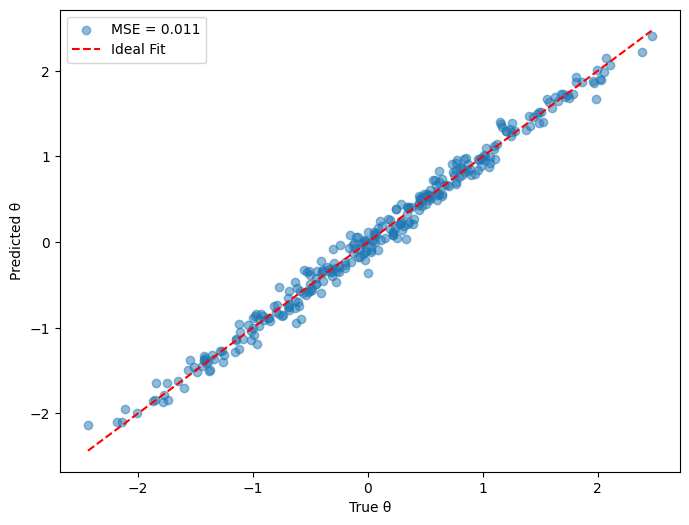

In [6]:
# Evaluate the model using the test data
predictions = inference.predict(X_test, scaler=scaler)

# Calculate MSE
mse = mean_squared_error(theta_test, predictions)

# Plot real vs predicted values
plt.figure(figsize=(8, 6))
plt.scatter(theta_test, predictions, alpha=0.5, label=f'MSE = {mse:.3f}')
plt.plot([theta_test.min(), theta_test.max()], [theta_test.min(), theta_test.max()], 'r--', label='Ideal Fit')
plt.xlabel('True θ')
plt.ylabel('Predicted θ')
plt.legend()
plt.show()

Alternatively, we can use the posterior distribution learned by the NPE model to sample from the parameter space given an observation.

In [7]:
import pickle
with open('data/density_estimator.pkl', 'rb') as f:
    density_estimator = pickle.load(f)
with open('data/model.pkl', 'rb') as f:
    inference = pickle.load(f)
with open('data/scaler.pkl', 'rb') as f:
    scaler = pickle.load(f)

posterior = inference.build_posterior(density_estimator)
print(posterior) # prints how the posterior was trained

Posterior p(θ|x) of type DirectPosterior. It samples the posterior network and rejects samples that
            lie outside of the prior bounds.


We can now sample from the posterior distribution given an observation and visualize pairwise relationships between the parameters using a pairplot.

x_obs: [[1.01500671 0.31431296 1.22458069]]


Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

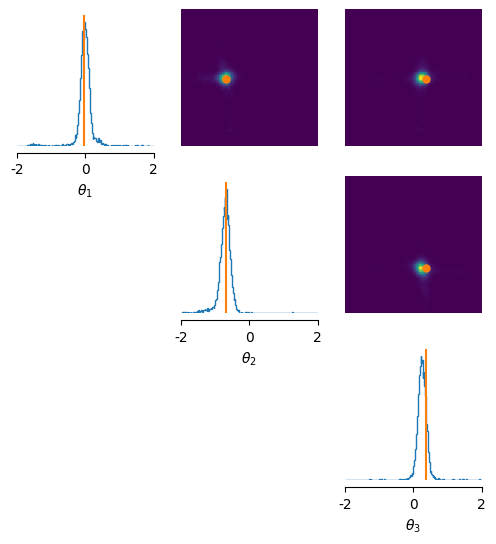

In [8]:
from sbi.analysis import pairplot
import torch

# Generate our observation
theta_true = np.random.randn(1, num_dim)
x_obs = simulator(theta_true)
print('x_obs:', x_obs)

# Scale the observation and convert to tensor
x_obs = scaler.transform(x_obs)
x_obs = torch.tensor(x_obs, dtype=torch.float32)

# Sample from the posterior distribution and plot the results
samples = posterior.sample((10000,), x=x_obs)
_ = pairplot(samples,
             points=theta_true,
             limits=[[-2, 2], [-2, 2], [-2, 2]],
             figsize=(6, 6),
             labels=[r"$\theta_1$", r"$\theta_2$", r"$\theta_3$"])